# Modeling and Simulation in Python

Chapter 24

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [10]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Rolling paper

We'll start by loading the units we need.

In [11]:
radian = UNITS.radian
m = UNITS.meter
s = UNITS.second

<Unit('second')>

And creating a `Params` object with the system parameters

In [12]:
params = Params(Rmin = 0.02 * m,
                Rmax = 0.055 * m,
                L = 47 * m,
                t_end = 130 * s)

,values
Rmin,0.02 meter
Rmax,0.055 meter
L,47 meter
t_end,130 second


The following function estimates the parameter `k`, which is the increase in the radius of the roll for each radian of rotation. 

In [13]:
def estimate_k(params):
    """Estimates the parameter `k`.
    
    params: Params with Rmin, Rmax, and L
    
    returns: k in meters per radian
    """
    unpack(params)
    
    Ravg = (Rmax + Rmin) / 2
    Cavg = 2 * pi * Ravg
    revs = L / Cavg
    rads = 2 * pi * revs
    k = (Rmax - Rmin) / rads
    return k

As usual, `make_system` takes a `Params` object and returns a `System` object.

In [14]:
def make_system(params):
    """Make a system object.
    
    params: Params with Rmin, Rmax, and L
    
    returns: System with init, k, and ts
    """
    unpack(params)
    
    init = State(theta = 0 * radian,
                 y = 0 * m,
                 r = Rmin)
    
    k = estimate_k(params)
    
    return System(init=init, k=k, t_end=t_end)

Testing `make_system`

In [15]:
system = make_system(params)

,values
init,theta 0 radian y 0 meter r ...
k,2.7925531914893616e-05 meter
t_end,130 second


In [16]:
system.init

,values
theta,0 radian
y,0 meter
r,0.02 meter


Now we can write a slope function based on the differential equations

$\omega = \frac{d\theta}{dt} = 10$

$\frac{dy}{dt} = r \frac{d\theta}{dt}$

$\frac{dr}{dt} = k \frac{d\theta}{dt}$


In [17]:
def slope_func(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    unpack(system)
    
    omega = 10 * radian / s
    dydt = r * omega
    drdt = k * omega
    
    return omega, dydt, drdt

Testing `slope_func`

In [18]:
slope_func(system.init, 0*s, system)

(<Quantity(10.0, 'radian / second')>,
 <Quantity(0.2, 'meter * radian / second')>,
 <Quantity(0.0002792553191489362, 'meter * radian / second')>)

We'll use an event function to stop when `y=L`.

In [19]:
def event_func(state, t, system):
    """Detects when we've rolled length `L`.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: difference between `y` and `L`
    """
    theta, y, r = state
    unpack(system)
    
    return y - L

Now we can run the simulation.

In [20]:
results, details = run_ode_solver(system, slope_func, events=event_func, max_step=1*s)
details

,values
sol,None
t_events,[[125.33333333333341]]
nfev,782
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


And look at the results.

In [21]:
results.tail()

,theta,y,r
122.057979,1220.579789,45.213534,0.054085
123.057979,1230.579789,45.755784,0.054365
124.057979,1240.579789,46.300826,0.054644
125.057979,1250.579789,46.848661,0.054923
125.333333,1253.333333,47.000000,0.055000


The final value of `y` is 47 meters, as expected.

In [22]:
unrolled = get_last_value(results.y) * m

<Quantity(47.0, 'meter')>

The final value of radius is `R_max`.

In [23]:
radius = get_last_value(results.r) * m

<Quantity(0.054999999999999945, 'meter')>

The total number of rotations is close to 200, which seems credible.

In [24]:
rotation = get_last_value(results.theta) / 2 / np.pi

199.4741953418423

The elapsed time is plausible.

In [25]:
t_final = get_last_label(results) * s

<Quantity(125.33333333333341, 'second')>

### Plotting

Plotting `theta`

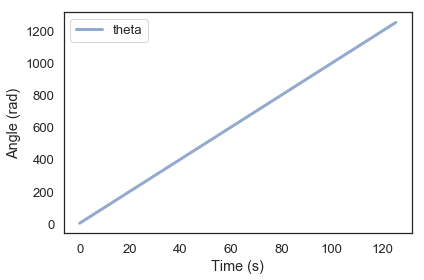

In [26]:
def plot_theta(results):
    plot(results.theta, color='C0', label='theta')
    decorate(xlabel='Time (s)',
             ylabel='Angle (rad)')
    
plot_theta(results)

Plotting `y`

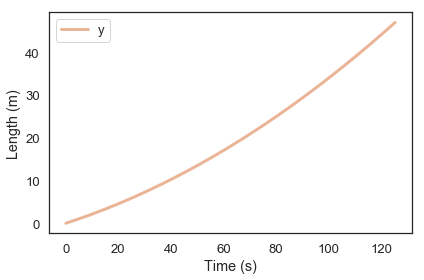

In [27]:
def plot_y(results):
    plot(results.y, color='C1', label='y')

    decorate(xlabel='Time (s)',
             ylabel='Length (m)')
    
plot_y(results)

Plotting `r`

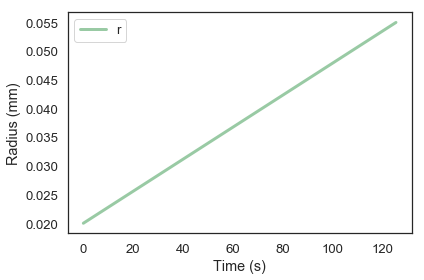

In [28]:
def plot_r(results):
    plot(results.r, color='C2', label='r')

    decorate(xlabel='Time (s)',
             ylabel='Radius (mm)')
    
plot_r(results)

We can also see the relationship between `y` and `r`, which I derive analytically in the book.

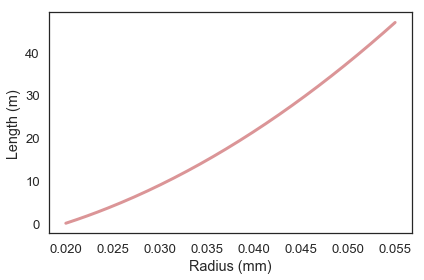

In [29]:
plot(results.r, results.y, color='C3')

decorate(xlabel='Radius (mm)',
         ylabel='Length (m)',
         legend=False)

And here's the figure from the book.

Saving figure to file figs/chap11-fig01.pdf


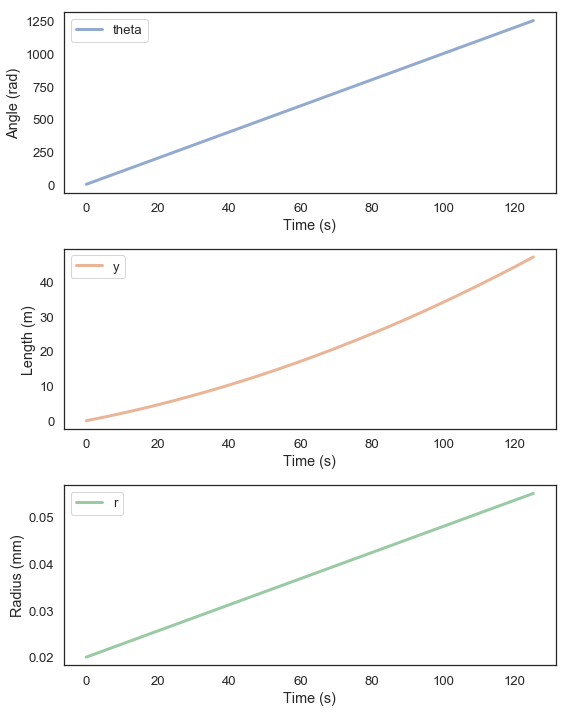

In [30]:
def plot_three(results):
    subplot(3, 1, 1)
    plot_theta(results)

    subplot(3, 1, 2)
    plot_y(results)

    subplot(3, 1, 3)
    plot_r(results)

plot_three(results)
savefig('figs/chap11-fig01.pdf')

### Exercises

**Exercise:** Since we keep `omega` constant, the linear velocity of the paper increases with radius.  Use `gradient` to estimate the derivative of `results.y`.  What is the peak linear velocity?

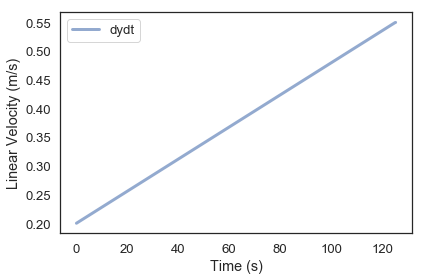

In [33]:
# Solution goes here
dydt = gradient(results.y)
plot(dydt, label='dydt')
decorate(xlabel='Time (s)',
         ylabel='Linear Velocity (m/s)')

In [35]:
# Solution goes here
peak_linear_velocity = get_last_value(dydt) * m/s

<Quantity(0.5496155290513908, 'meter / second')>

Now suppose the peak velocity is the limit; that is, we can't move the paper any faster than that.

Nevertheless, we might be able to speed up the process by keeping the linear velocity at the maximum all the time.

Write a slope function that keeps the linear velocity, `dydt`, constant, and computes the angular velocity, `omega`, accordingly.

Run the simulation and see how much faster we could finish rolling the paper.

In [36]:
# Solution goes here
def slope_func2(state, t, system):
    """Computes the derivatives of the state variables.
    
    state: State object with theta, y, r
    t: time
    system: System object with r, k
    
    returns: sequence of derivatives
    """
    theta, y, r = state
    unpack(system)
    
    dydt = 0.5496155290513908 * m/s
    omega = dydt / r
    drdt = k * omega
    
    return omega, dydt, drdt

In [37]:
# Solution goes here
slope_func2(system.init, 0*s, system)

(<Quantity(27.48077645256954, '1 / second')>,
 <Quantity(0.5496155290513908, 'meter / second')>,
 <Quantity(0.0007674152998722876, 'meter / second')>)

In [38]:
# Solution goes here
results, details = run_ode_solver(system, slope_func2, events=event_func, max_step=1*s)
details

,values
sol,None
t_events,[[85.51432322358069]]
nfev,548
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [39]:
# Solution goes here
results.tail()

,theta,y,r
82.384989,1221.809583,45.280069,0.054120
83.384989,1231.938670,45.829685,0.054403
84.384989,1242.015363,46.379300,0.054684
85.384989,1252.040468,46.928916,0.054964
85.514323,1253.333333,47.000000,0.055000


In [40]:
t_final = get_last_label(results) * s

<Quantity(85.51432322358069, 'second')>

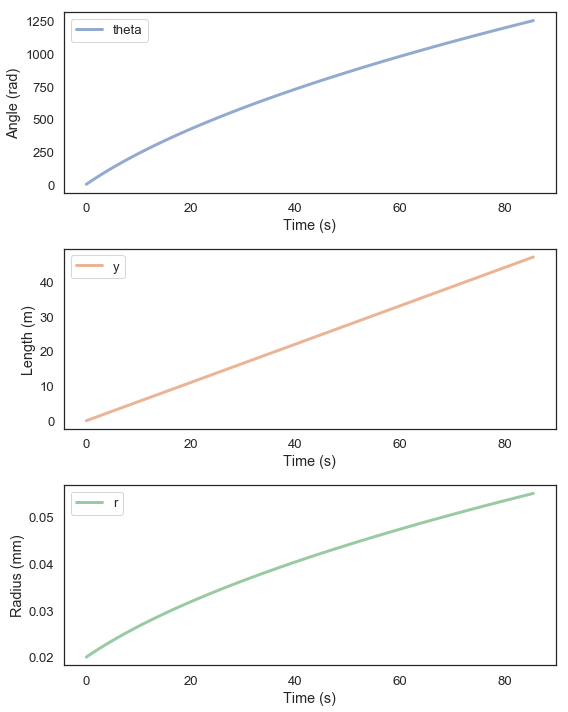

In [41]:
plot_three(results)